### Check on new formulas from Manish, date: 1/9/18

In [1]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from time import time


### import tables

In [3]:
def print_table(table):
    print(len(table), table.columns)
    

In [4]:
def import_tables(product, data_dir):
    product_dir = "".join([data_dir,product,'/'])

    invoice_date = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_DOC_KEY_DTLS_",product,".txt"]), sep = "|")
#     print('invoice_date')
#     print_table(invoice_date)
    
    invoice_amount = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_DOC_PROC_DTLS_",product,".txt"]), sep = "|")
#     print('invoice_amount')
#     print_table(invoice_amount)
    
    deal_hist = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_DEAL_HIST_",product,".txt"]), sep = "|")
#     print('deal_hist')
#     print_table(deal_hist)
    
    rff = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_RFF_ALLOC_DTLS_",product,".txt"]), sep = "|")
    rff['fin_ccy_amt'] =  rff.fin_ccy_cp_alloc_amt  + rff.fin_ccy_ncp_alloc_amt  
#     print('rff')
#     print_table(rff)
    
    rff_dtls = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_RFF_DTLS_",product,".txt"]), sep = "|")
#     print('rff_dtls')
#     print_table(rff_dtls)
    
    pymt = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_PYMT_ALLOC_DTLS_",product,".txt"]), sep = "|")
    pymt['pymt_ccy_amt'] = pymt.fin_ccy_cp_liq_amt  + pymt.fin_ccy_ncp_liq_amt   +  pymt.pymt_ccy_cp_adj_amt  + pymt.pymt_ccy_ncp_adj_amt  
#     print('pymt')
#     print_table(pymt)

    if product == 'RSRV':
        invoice_detail = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_DOC_ADDL_DTLS_",product,"1.csv"]))
        pymt_dtls = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_PYMT_DTLS_",product,".csv"]))
    else: 
        invoice_detail = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_DOC_ADDL_DTLS_",product,".txt"]), sep = "|")
        pymt_dtls = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_PYMT_DTLS_",product,".txt"]), sep = "|")
#     print('invoice_detail')
#     print_table(invoice_detail)
#     print('pymt_dtls')
#     print_table(pymt_dtls)

    return invoice_date,invoice_amount,deal_hist,rff,pymt,invoice_detail, rff_dtls, pymt_dtls

### convert to usd

In [5]:
# # new x_rate file from Google
# update through google sheets: 
#     =GOOGLEFINANCE("inrusd","price",date(2017,1,1),date(2017,11,30))


def load_x_rate(x_rate_csv):

    x_rate = pd.read_csv(x_rate_csv)
    x_rate['date_stamp']=[pd.Timestamp(x) for x in x_rate.Date]
    x_rate['yr_mo'] = [str(x)[:7] for x in x_rate.date_stamp]
    x_rate = x_rate.groupby(['CCY','yr_mo']).agg({'Rate':np.mean})
    x_rate.reset_index(level=['CCY','yr_mo'], inplace=True)
    return x_rate

In [6]:
#convert amounts to usd
def covert_to_usd(table):
    #input table columns: ccy code, date, amt
    table.columns = ['CCY','Date', 'amt']
    table['date_stamp']=[pd.Timestamp(x) for x in table.Date]
    table['yr_mo'] = [str(x)[:7] for x in table.date_stamp]
#     table['yr_mo'] = [x[:7] for x in table.Date]
    table = table.merge(x_rate, how = 'left', on = ['CCY','yr_mo'])
    table['Rate'] = np.where(table.CCY == 'USD',1., table.Rate)
#     table['amt_usd'] = table.amt/table.Rate
    
    return table.Rate

x_rate_csv = 'daily_x_rate.csv'
x_rate = load_x_rate(x_rate_csv)

In [11]:
# products = ['BATB', 'BDBR', 'ECIF', 'ECPR', 'IFNB', 'IFNS', 'LBDS', 'LRRP', 'PSHP', 'TRDS', 'RSRV']
products = [ 'ECIF', 'ECPR', 'IFNB', 'IFNS', 'LBDS', 'LRRP', 'PSHP', 'TRDS', 'RSRV']
# product = "IFNS"
data_dir = '/home/ec2-user/SCB_DATA/FROM_SCB_TXT/'

182
(182, 182, 182)


/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ECIF
('nrows', 182)
('n doc_id', 182)
       supplier_id      buyer_id        rec_id   doc_ccy_amt       tenor  \
count        182.0  1.820000e+02  1.820000e+02  1.820000e+02  182.000000   
mean   100129547.0  1.001873e+08  1.682370e+09  4.735110e+05   57.571429   
std            0.0  9.590838e+04  9.748684e+08  3.555706e+05   12.698930   
min    100129547.0  1.000236e+08  2.663934e+08  1.890000e+05   23.000000   
25%    100129547.0  1.001303e+08  1.261156e+09  2.370000e+05   52.000000   
50%    100129547.0  1.002427e+08  1.627225e+09  4.530000e+05   58.000000   
75%    100129547.0  1.002843e+08  2.407437e+09  5.140000e+05   60.000000   
max    100129547.0  1.002937e+08  3.986658e+09  2.280000e+06   95.000000   

       grace_period   fin_tenor   to_seq_no  from_seq_no  \
count         182.0  182.000000  182.000000        182.0   
mean            0.0   57.571429   82.598901          1.0   
std             0.0   12.698930   41.736593          0.0   
min             0.0   23.000000    4.

/home/ec2-user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/ec2-user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


2905667
(820920, 2862496, 319185)


ValueError: could not convert string to Timestamp

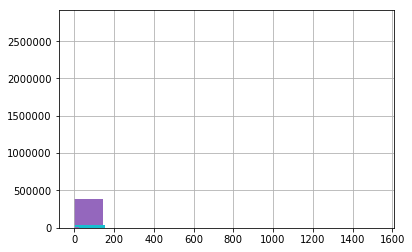

In [12]:
for product in products:
    invoice_date,invoice_amount,deal_hist,rff,pymt,invoice_detail, rff_dtls, pymt_dtls = import_tables(product, data_dir)

    s= time()
    #merge doc data
    inv_det = inv_det = invoice_date[[
            'cty_code', 'rec_id', 'deal_rec_id', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'doc_date', 'deal_id'
        ]].merge(invoice_amount[[
            'rec_id', 'doc_id', 'doc_ccy_code', 'doc_ccy_amt', 'fin_flag']], 
                                        how= 'inner', on = ['doc_id', 'rec_id']).merge(invoice_detail[[
            'rec_id', 'doc_id', 'tenor', 'tenor_start_date', 'due_date', 'grace_period', 'maturity_date', 
            'fin_tenor_start_date', 'fin_tenor', 'to_seq_no', 'from_seq_no']], how= 'inner', on = ['doc_id', 'rec_id'])

    len(inv_det), inv_det.columns

    inv_det_doc = inv_det.groupby(['cty_code', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'deal_id', 'fin_flag']).agg({'rec_id':'max'})
    inv_det_doc.reset_index(level = ['cty_code', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'deal_id', 'fin_flag'], inplace = True)
    len(inv_det_doc), len(pd.unique(inv_det_doc.doc_id))
    inv_det_doc = inv_det_doc.merge(inv_det, how = 'left', on =['cty_code', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'deal_id', 'fin_flag', 'rec_id'])
    len(inv_det_doc), len(pd.unique(inv_det_doc.doc_id))

    #rff data
    rff_lookup = rff.groupby('doc_id').agg({'deal_rec_id':'max'})
    rff_lookup.reset_index(level = 'doc_id', inplace = True)
    len(rff_lookup),rff_lookup.head()

    rff_dedup_amt = rff_lookup.merge(rff[['doc_id', 'deal_rec_id','fin_ccy_code', 'fin_ccy_cp_alloc_amt', 'fin_ccy_ncp_alloc_amt',
                                   'fin_ccy_ncp_os_amt', 'fin_ccy_cp_os_amt']] , on = ['doc_id', 'deal_rec_id'], how = 'inner')
    len(rff_dedup_amt),len(rff_lookup)

    # Financed amount : fin_ccy_cp_alloc_amt + fin_ccy_ncp_alloc_amt
    # Outstanding : fin_ccy_ncp_os_amt + fin_ccy_cp_os_amt

    rff_dedup_amt['fin_ccy_amt'] = rff_dedup_amt.fin_ccy_cp_alloc_amt + rff_dedup_amt.fin_ccy_ncp_alloc_amt
    rff_dedup_amt['os_ccy_amt'] = rff_dedup_amt.fin_ccy_ncp_os_amt + rff_dedup_amt.fin_ccy_cp_os_amt
    rff_dedup_amt['pymt_ccy_amt']=rff_dedup_amt.fin_ccy_amt - rff_dedup_amt.os_ccy_amt
    rff_dedup_amt['dr'] = rff_dedup_amt.os_ccy_amt / rff_dedup_amt.fin_ccy_amt
    rff_dedup_amt.describe()
    rff_dedup_amt.dr.hist();

    print(len(rff_dedup_amt))
    rff_dedup_amt = rff_dedup_amt.merge(rff_dtls[['deal_rec_id','start_date']], on = 'deal_rec_id', how = 'inner')
    len(rff_dedup_amt)

    inv_det_doc_rff = inv_det_doc.merge(rff_dedup_amt, how = 'inner', on = 'doc_id')
    print(len(inv_det_doc), len(rff_dedup_amt), len(inv_det_doc_rff))
    inv_det_doc_rff.describe()

    #settled_deal_hist
    # Deal Hist.Sale_Ledger_Flag = “Y” and Deal_Hist. pool_based_flag = “N” and Deal Hist.Step_Code = “SETT”
    settled_deal_hist = deal_hist[(deal_hist.sale_ledger_flag=='Y')
                                 &(deal_hist.pool_based_flag=='N')
                                  &(deal_hist.step_code=='SETT')
                                 ][['sale_ledger_flag','pool_based_flag','step_code','deal_id',
                                    'product_variant_code', 'rel_seq_no', 'value_date']]
    settled_deal_hist.drop_duplicates(inplace = True)
    len(settled_deal_hist)

    # Deal Hist.Deal_ID = Doc Addt Details.Deal_ID and Deal Hist.Rel_Seq_No = Doc Addt Details.To_Seq_No
    settled_doc = inv_det_doc_rff.merge(settled_deal_hist, how = 'inner', left_on = ['deal_id', 'to_seq_no'], 
                                        right_on=['deal_id', 'rel_seq_no'])
    len(settled_doc)
    len(pd.unique(settled_doc.doc_id))

    # unsettled_doc
    # Deal Hist.Sale_Ledger_Flag = “Y” and Deal_Hist. pool_based_flag = “N” And Deal Hist.Step_Code IN (‘NEW’, ‘RFF’)
    # And Deal Hist.Deal_ID = Doc Addt Details.Deal_ID And Doc Addt Details.To_Seq_No = null
    unsettled_deal_hist = deal_hist[(deal_hist.sale_ledger_flag=='Y')
                                 &(deal_hist.pool_based_flag=='N')
                                  &(deal_hist.step_code.isin(['NEW','RFF']))
                                 ][['sale_ledger_flag','pool_based_flag','step_code','deal_id', 
                                    'product_variant_code', 'value_date']]
    unsettled_deal_hist.drop_duplicates(inplace = True)
    len(unsettled_deal_hist)
    unsettled_deal_hist = unsettled_deal_hist.groupby(['sale_ledger_flag','pool_based_flag','deal_id', 
                                    'product_variant_code']).agg({'value_date':'max', 'step_code':'max'})
    unsettled_deal_hist.reset_index(level = ['sale_ledger_flag','pool_based_flag','deal_id', 
                                    'product_variant_code'], inplace = True)
    len(unsettled_deal_hist)
    # Deal Hist.Deal_ID = Doc Addt Details.Deal_ID and Deal Hist.Rel_Seq_No = Doc Addt Details.To_Seq_No
    unsettled_doc = inv_det_doc_rff.merge(unsettled_deal_hist, how = 'inner', on = 'deal_id')
    unsettled_doc = unsettled_doc[pd.isnull(unsettled_doc.to_seq_no)==True]
    unsettled_doc['rel_seq_no'] = None
    len(unsettled_doc)

    # Deal Hist.Deal_ID = Doc Addt Details.Deal_ID and Doc Addt Details.To_Seq_No is null
    unsettled_doc = inv_det_doc_rff.merge(unsettled_deal_hist, how = 'inner', on = 'deal_id')
    unsettled_doc = unsettled_doc[pd.isnull(unsettled_doc.to_seq_no)==True]
    unsettled_doc['rel_seq_no'] = None
    len(unsettled_doc)

    #merge settled and unsettled data
    settled_doc['settled_flag'] = 'Y'
    unsettled_doc['settled_flag'] = 'N'
    unsettled_doc = unsettled_doc[list(settled_doc.columns)]
    data_rec_id = settled_doc.append(unsettled_doc, ignore_index=True)
    len(data_rec_id), data_rec_id.dr.hist()

    data_rec_id.groupby(['fin_flag', 'settled_flag']).agg({'doc_id':'count'})

    data_rec_id.drop(['deal_rec_id_y', 'deal_rec_id_x'],axis = 1, inplace=True)
    data_rec_id.drop_duplicates(inplace=True)
    len(data_rec_id), len(pd.unique(data_rec_id.doc_id))

    data_rec_id.rename({'start_date':'fin_date', 'value_date':'pymt_date',}, axis=1, inplace = True)
    data_rec_id.columns

    data_doc = data_rec_id

    # convert dates to timestamps
    fin_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.fin_date ]
#     print(fin_date[-5 :])
#     (fin_date[0]-fin_date[3]).days

    pymt_date = [pd.Timestamp(x) for x in data_doc.pymt_date]
#     print(pymt_date[-3:])
#     (pymt_date[0]-pymt_date[3]).days

    due_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.due_date]
#     print(due_date[-3:])
#     (due_date[0]-due_date[3]).days

    maturity_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.maturity_date]
#     print(maturity_date[-3:])
#     (maturity_date[0]-maturity_date[3]).days

#     doc_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.doc_date]
#     print(doc_date[-3:])
#     (doc_date[0]-doc_date[3]).days

    doc_date = []
    for i in range(len(data_doc)):
        try:
            doc_date.append(pd.Timestamp(data_doc.doc_date[i]))
        except:
            doc_date.append(pd.Timestamp('2017-11-30'))

    data_doc['fin_date'] = fin_date
    data_doc['pymt_date'] = pymt_date
    data_doc['due_date'] = due_date
    data_doc['maturity_date'] = maturity_date
    data_doc['doc_date'] = doc_date

    late_days = [max(0,(x-y).days) for x,y in zip(pymt_date, due_date)]
    finance_days = [max(0,(x-y).days) for x,y in zip(pymt_date, fin_date)]
    finance_due_days = [max(0,(x-y).days) for x,y in zip(due_date, fin_date)]

    data_doc['late_days'] = late_days
    data_doc['finance_days'] = finance_days
    data_doc['finance_due_days'] = finance_due_days

    #calcluate predictees
    data_doc['isLate'] = np.where(data_doc.late_days>0, 1,0)
    data_doc['late_days_bucket'] = np.where(data_doc.late_days>30, 2,np.where(data_doc.late_days>0,1,0))
    data_doc.late_days_bucket.hist();

    data_doc['dr_bucket'] = np.where(data_doc.dr>.05,2, np.where(data_doc.dr>0,1,0))
    data_doc.dr_bucket.hist();


    data_doc.late_days.hist()

    #convert amts to usd
    table = data_doc[['fin_ccy_code', 'fin_date', 'fin_ccy_amt']]
    data_doc['fin_xrate'] = covert_to_usd(table)

    #doc amount

    table = data_doc[['doc_ccy_code', 'doc_date', 'doc_ccy_amt']]
    data_rec_id['doc_xrate'] = covert_to_usd(table)

    data_doc['doc_usd_amt'] = data_doc.doc_ccy_amt*data_doc.doc_xrate
    data_doc['fin_usd_amt'] = data_doc.fin_ccy_amt*data_doc.fin_xrate
    data_doc['os_usd_amt'] = data_doc.os_ccy_amt*data_doc.fin_xrate
    data_doc['pymt_usd_amt'] = data_doc.pymt_ccy_amt*data_doc.fin_xrate

    print(product)
    print("nrows",len(data_doc))
    print("n doc_id",len(pd.unique(data_doc.doc_id)))
    print(data_doc.describe())
    print(data_doc.tail())

    data_doc.to_csv("".join(['/home/ec2-user/SCB_CODE/cam_code/data_180112/data_3NF_180112_',product,'.csv']))

    e = time()
    print(e-s)/60

In [13]:
data_doc.head()

,cty_code,doc_id,supplier_id,buyer_id,doc_type_code,deal_id,fin_flag,rec_id,doc_date,doc_ccy_code,...,pymt_ccy_amt,dr,fin_date,sale_ledger_flag,pool_based_flag,step_code,product_variant_code,rel_seq_no,pymt_date,settled_flag
0,AE,1DH6JWCLKN-22243,100125338,100344238.0,INV,TF123R0032,Y,735666975,2016-11-21 00:00:00,AED,...,624.0,0.0,2016-11-30 00:00:00,Y,N,SETT,RSRV01,1293,2016-12-07 00:00:00,Y
1,AE,1DH6JWCLKN-22244,100125338,100344238.0,INV,TF123R0032,Y,735666977,2016-11-21 00:00:00,AED,...,10616.0,0.0,2016-11-30 00:00:00,Y,N,SETT,RSRV01,1293,2016-12-07 00:00:00,Y
2,AE,1DH6JWCLKN-23441,100125338,100344231.0,INV,TF123R0032,Y,735667371,2016-11-26 00:00:00,AED,...,864.0,0.0,2016-11-30 00:00:00,Y,N,SETT,RSRV01,1473,2017-02-19 00:00:00,Y
3,AE,1DH6JWCLKN-23442,100125338,100344231.0,INV,TF123R0032,Y,735667373,2016-11-26 00:00:00,AED,...,50456.0,0.0,2016-11-30 00:00:00,Y,N,SETT,RSRV01,1473,2017-02-19 00:00:00,Y
4,AE,1DH6JWCLKN-43354,100125338,100344231.0,INV,TF123R0032,Y,735747397,2016-11-14 00:00:00,AED,...,72420.0,0.0,2016-11-30 00:00:00,Y,N,SETT,RSRV01,1473,2017-02-19 00:00:00,Y


/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RSRV
('nrows', 241022)
('n doc_id', 240580)
        supplier_id      buyer_id   doc_ccy_amt          tenor   grace_period  \
count  2.410220e+05  2.410220e+05  2.410220e+05  241022.000000  241022.000000   
mean   1.002155e+08  1.002009e+08  2.649311e+06      72.289969       8.727917   
std    1.173345e+05  1.113090e+05  1.634825e+07     121.796790      22.342594   
min    1.000019e+08  1.000000e+08  3.000000e-02       0.000000       0.000000   
25%    1.001156e+08  1.001169e+08  5.203400e+02      30.000000       0.000000   
50%    1.002453e+08  1.002257e+08  1.103151e+04      60.000000       0.000000   
75%    1.003069e+08  1.003068e+08  7.318910e+04      90.000000       4.000000   
max    1.004155e+08  1.004200e+08  1.391859e+09    2988.000000     750.000000   

           fin_tenor      to_seq_no    from_seq_no  fin_ccy_cp_alloc_amt  \
count  241022.000000  230105.000000  241022.000000          2.410220e+05   
mean       86.050178    3889.294218    3497.281622          2.584481e+06  

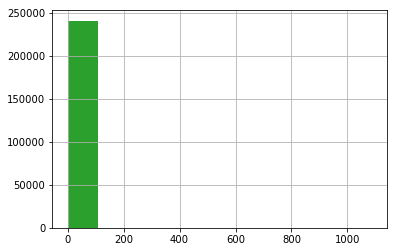

In [17]:
# pymt_date = [pd.Timestamp(x) for x in data_doc.pymt_date]
# #     print(pymt_date[-3:])
#     (pymt_date[0]-pymt_date[3]).days

# due_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.due_date]
#     print(due_date[-3:])
#     (due_date[0]-due_date[3]).days

# maturity_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.maturity_date]
#     print(maturity_date[-3:])
#     (maturity_date[0]-maturity_date[3]).days

#     doc_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.doc_date]
#     print(doc_date[-3:])
#     (doc_date[0]-doc_date[3]).days

doc_date = []
for i in range(len(data_doc)):
    try:
        doc_date.append(pd.Timestamp(data_doc.doc_date[i]))
    except:
        doc_date.append(None)
        
pymt_date = []
for i in range(len(data_doc)):
    try:
        pymt_date.append(pd.Timestamp(data_doc.pymt_date[i]))
    except:
        pymt_date.append(None)
        
due_date = []
for i in range(len(data_doc)):
    try:
        due_date.append(pd.Timestamp(data_doc.due_date[i]))
    except:
        due_date.append(None)
        
maturity_date = []
for i in range(len(data_doc)):
    try:
        maturity_date.append(pd.Timestamp(data_doc.maturity_date[i]))
    except:
        maturity_date.append(None)

data_doc['fin_date'] = fin_date
data_doc['pymt_date'] = pymt_date
data_doc['due_date'] = due_date
data_doc['maturity_date'] = maturity_date
data_doc['doc_date'] = doc_date

late_days = [max(0,(x-y).days) for x,y in zip(pymt_date, due_date)]
finance_days = [max(0,(x-y).days) for x,y in zip(pymt_date, fin_date)]
finance_due_days = [max(0,(x-y).days) for x,y in zip(due_date, fin_date)]

data_doc['late_days'] = late_days
data_doc['finance_days'] = finance_days
data_doc['finance_due_days'] = finance_due_days

#calcluate predictees
data_doc['isLate'] = np.where(data_doc.late_days>0, 1,0)
data_doc['late_days_bucket'] = np.where(data_doc.late_days>30, 2,np.where(data_doc.late_days>0,1,0))
data_doc.late_days_bucket.hist();

data_doc['dr_bucket'] = np.where(data_doc.dr>.05,2, np.where(data_doc.dr>0,1,0))
data_doc.dr_bucket.hist();


data_doc.late_days.hist()

#convert amts to usd
table = data_doc[['fin_ccy_code', 'fin_date', 'fin_ccy_amt']]
data_doc['fin_xrate'] = covert_to_usd(table)

#doc amount

table = data_doc[['doc_ccy_code', 'doc_date', 'doc_ccy_amt']]
data_rec_id['doc_xrate'] = covert_to_usd(table)

data_doc['doc_usd_amt'] = data_doc.doc_ccy_amt*data_doc.doc_xrate
data_doc['fin_usd_amt'] = data_doc.fin_ccy_amt*data_doc.fin_xrate
data_doc['os_usd_amt'] = data_doc.os_ccy_amt*data_doc.fin_xrate
data_doc['pymt_usd_amt'] = data_doc.pymt_ccy_amt*data_doc.fin_xrate

print(product)
print("nrows",len(data_doc))
print("n doc_id",len(pd.unique(data_doc.doc_id)))
print(data_doc.describe())
print(data_doc.tail())

data_doc.to_csv("".join(['/home/ec2-user/SCB_CODE/cam_code/data_180112/data_3NF_180112_',product,'.csv']))

e = time()
print(e-s)/60